In [1]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [4]:
bill_text_df_cleaned = prepare_bill_text_for_clean_df(bill_text_df)

In [5]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
        
    def remove_neg(num):
        if num < 0:
            return 0
        else: return num
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)
    
    clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])
    clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']
    clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)
    
    return clean

In [6]:
clean = create_clean_X(merged_final_df, bill_text_df_cleaned, rep_score_df)

# Create controversy_topics_df

In [90]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")
topic_df['bill_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_id'].apply(str)
topic_df = topic_df.drop(['biennium', 'Unnamed: 0'], axis=1)
controversy_topics_df = controversy_X.merge(topic_df, how='left', on='bill_unique')
controversy_topics_df = controversy_topics_df[controversy_topics_df['HORSE'].notnull()]

# Group by party

In [101]:
clean_topics = clean.merge(topic_df, how='left', on='bill_unique')

In [143]:
party_grouped = clean_topics.groupby('vote').mean()

In [144]:
party_grouped.shape

(2, 371)

In [147]:
party_grouped.iloc[:, 20:30]

,PROPERTY,ABORTION,GOVERNMENT OPERATIONS AND POLITICS,ACCOUNTANTS AND ACCOUNTING,"CIVIL RIGHTS AND LIBERTIES, MINORITY ISSUES",NATROPATH,ADMINISTRATIVE,ADVERTISING,FAMILY,ADULT ENTERTAINMENT
vote,,,,,,,,,,
0,0.033861,0.004631,0.306202,0.000570,0.043577,0.003079,0.020664,0.004895,0.021540,0.000565
1,0.038100,0.000518,0.178339,0.001214,0.049493,0.002678,0.011027,0.003012,0.018822,0.000228


In [148]:
# MORE likely to vote yea
yea_topics = ['PROPERTY', 'ACCOUNTANTS AND ACCOUNTING', 'EMERGENCY MANAGEMENT AND SERVICES', 'ANATOMIC GIFTS', 
'HORTICULTURE AND AQUACULTURE', 'JUDICIAL', 'HISTORY AND ARCHAEOLOY', 'RECORDS', 'LAW AND JUSTICE', 
'ATTORNEYS', 'AUCTIONS AND AUCTIONEERS', 'AUDITORS AND AUDITING', 'FINANCE AND FINANCIAL SECTOR', 
'DISABILITIES', 'BOUNDARIES', 'CEMETERIES', 'CHARITABLE DONATIONS', 'COMMUNITY PROPERTY', 'INTERSTATE', 
'COSMETICS', 'DEPENDENT ADULTS', 'MEDICAL', 'ELECTRICITY', 'EXPLOSIVES', 'FLOOD', 'FUNERAL', 'HEATING',
'LEASES', 'LONGSHORE AND HARBOR WORKERS', 'MILITARY', 'MINES AND MINING', 'MUNICIPAL COURT', 'NONPROFIT', 
'OPEN PUBLIC MEETINGS', 'DISCLOSURE', 'SECURITY', 'SPECIAL PURPOSE DISTRICTS', 'TOWING AND TOW TRUCKS', 
'TRUSTS', 'UNIFORM ACTS', 'VOLUNTEERS', 'STORAGE', 'WAREHOUSING']

In [152]:
# LESS likely to vote yea
nay_topics = ['GOVERNMENT OPERATIONS', 'ABORTION', 'NATROPATH', 'ADVERTISING', 'LONG TERM CARE', 'FAMILY', 'BUSINESS', 
'ENVIRONMENT', 'TRANSPORTATION', 'ARTS AND CULTURE', 'SAFETY', 'SCIENCE, TECHNOLOGY, COMMUNICATIONS', 
'ELECTIONS', 'BUILDING', 'CAPITOL', 'CITIES AND TOWNS', 'RELIGION', 'TOBACCO', 'COUNTY',
'ECONOMY, DEVELOPMENT AND INTERNATIONAL', 'COMMUNITY SERVICE', 'CONVENTION AND TRADE CENTERS', 'MARRIAGE',
'DISTRESSED AREAS', 'EDUCATION', 'UTILITIES', 'LABOR AND EMPLOYMENT', 'ENERGY', 'GENE', 'HORSE RACING', 
'IDENTIFICATION', 'NATIVE AMERICANS', 'INSURANCE', 'WATER', 'JOINT RESOLUTIONS', 'TITLE', 'BUDGET', 'LOTTERY', 
'MAIL', 'METROPOLITAN MUNICIPAL CORPORATIONS', 'MEDIA', 'OPEN SPACES', 'PARKS', 'PERSONNEL', 'CIVIL SERVICE', 
'PUBLIC FACILITIES', 'PUBLIC FUNDS AND ACCOUNTS', 'SENIOR CITIZENS', 'TAXES', 'STUDIES', 'SUNSET REVIEW', 
'WEIGHTS AND MEASURES', 'CURFEW', 'IMMIGRATION', 'MANUFACTURING', 'MOVIES', 'REFERENDUM', 'PUGET SOUND', 
'NAMED ACTS']

In [153]:
# REP more likely to vote yea
rep_topics = ['ADMINISTRATIVE', 'ADULT ENTERTAINMENT', 'AGRICULTURE AND FOOD', 'ENVIRONMENT', 'DRUGS AND ALCOHOL', 
'RECREATION AND SPORTS', 'CITIZENSHIP', 'FISH AND WILDLIFE', 'SOCIAL WELFARE', 'RIVER', 'BUSINESSES', 
'ECONOMY, DEVELOPMENT AND INTERNATIONAL', 'CONTRACTS', 'DEATH', 'WEAPONS', 'ENGLISH LANGUAGE', 
'PARKS AND NATURAL RESOURCES', 'GAMBLING', 'HYDRAULIC', 'IMMUNITY', 'JOINT MEMORIALS', 'MARINE', 'NURSING HOMES',
'PEST CONTROL', 'PUBLIC LANDS AND NATURAL RESOURCES', 'TERRORISM', 'MANUFACTURING', 'MOTION PICTURES']

In [154]:
# DEM more likely to vote yea
dem_topics = ['CIVIL RIGHTS AND LIBERTIES, MINORITY ISSUES', 'HEALTH', 'HIGHER EDUCATION AND WORKFORCE TRAINING', 'HOUSING',
'PUBLIC WORKS', 'COUNTRIES', 'CHILDREN', 'CONTRACTORS', 'COUNSELORS AND COUNSELING', 'CITY AND TOWN', 'WASTE', 
'FEES', 'HOLIDAYS', 'PLACES', 'HUMAN REMAINS', 'INDIGENTS', 'PARKING', 'TRAFFIC', 'PUBLIC DEBTS', 'WELLS', 
'POLICY']

#### Make clean_four_topics

In [149]:
def make_yea_topics(row):
    topic_count = 0
    for topic in yea_topics:
        if row[topic] == 1:
            topic_count += 1
    return topic_count

In [155]:
def make_nay_topics(row):
    topic_count = 0
    for topic in nay_topics:
        if row[topic] == 1:
            topic_count += 1
    return topic_count

In [156]:
def make_rep_topics(row):
    topic_count = 0
    for topic in rep_topics:
        if row[topic] == 1:
            topic_count += 1
    return topic_count

In [157]:
def make_dem_topics(row):
    topic_count = 0
    for topic in dem_topics:
        if row[topic] == 1:
            topic_count += 1
    return topic_count

In [150]:
controversy_topics_df['yea_topics_score'] = controversy_topics_df.apply(make_yea_topics, axis=1)

In [158]:
controversy_topics_df['nay_topics_score'] = controversy_topics_df.apply(make_nay_topics, axis=1)

KeyError: ('GOVERNMENT OPERATIONS', 'occurred at index 0')

In [159]:
controversy_topics_df['rep_topics_score'] = controversy_topics_df.apply(make_rep_topics, axis=1)

In [160]:
controversy_topics_df['dem_topics_score'] = controversy_topics_df.apply(make_dem_topics, axis=1)

In [151]:
controversy_topics_df

,bill_unique,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,...,MEDALS,"PROFESSIONAL ENGINEERS AND LAND SURVEYORS, STATE BOARD OF REGISTRATION FOR",ROCKS AND MINERALS,LITTER,WASHINGTON STATE,CERTIFIED PROFESSIONAL GUARDIANSHIP BOARD,ELECTRICIANS,MUSICIANS,"PUBLIC GUARDIANSHIP, OFFICE",yea_topics_score
0,1991-92 2E2SSB 5780,275.776119,1.000000,5630.0,1.0,0.514925,0.485075,0.149254,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1991-92 2EHB 2168,246.921569,0.000000,2321.0,0.0,0.450980,0.450980,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1991-92 2ESB 5226,281.321918,1.000000,4607.0,1.0,0.506849,0.493151,0.061644,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1991-92 2ESB 6004,265.261780,0.471204,5986.0,1.0,0.481675,0.460733,0.000000,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,1991-92 2ESHB 1025,249.149809,0.041985,53.0,0.0,0.451336,0.449427,0.340649,0.0,0.305556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6,1991-92 2ESHB 1037,257.293605,0.139535,90.0,0.0,0.465116,0.465116,0.186047,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,1991-92 2ESHB 1058,259.265060,0.427711,141.0,0.0,0.472892,0.472892,0.012048,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,1991-92 2ESHB 1198,250.700508,0.000000,433.0,0.0,0.461929,0.461929,0.086294,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,1991-92 2ESHB 1378,261.875566,0.321267,816.0,0.0,0.470588,0.470588,0.061086,0.0,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
10,1991-92 2ESHB 1430,255.395189,0.319588,918.0,0.0,0.481100,0.470790,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Create controversy_score

In [7]:
clean = clean[clean['vote'] <= 1]

In [86]:
grouped = clean.groupby('bill_unique').mean()

In [87]:
grouped

,vote,voter_id,voting_agency,unique_id,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,...,index,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score
bill_unique,,,,,,,,,,,,,,,,,,,,,
1991-92 2E2SSB 5780,1.000000,275.776119,1.000000,5630.0,1.0,25.313433,0.514925,0.022388,0.485075,0.149254,...,5625.0,0.666667,0.333333,7396.0,1.0,8.0,1991.298507,1991.0,0.298507,0.000000
1991-92 2EHB 1033,0.570000,246.450000,0.000000,79.0,0.0,24.230000,0.460000,0.010000,0.460000,0.060000,...,77.0,0.285714,0.714286,1624.0,1.0,7.0,1991.000000,1991.0,0.000000,0.430000
1991-92 2EHB 2168,0.990196,246.921569,0.000000,2321.0,0.0,24.715686,0.450980,0.009804,0.450980,0.000000,...,2319.0,0.000000,1.000000,2430.0,1.0,1.0,1991.000000,1991.0,0.000000,0.009804
1991-92 2ESB 5226,0.486301,281.321918,1.000000,4607.0,1.0,24.883562,0.506849,0.020548,0.493151,0.061644,...,4604.0,1.000000,0.000000,2323.0,1.0,4.0,1991.000000,1991.0,0.000000,0.513699
1991-92 2ESB 6004,0.837696,265.261780,0.471204,5986.0,1.0,24.952880,0.481675,0.010471,0.460733,0.000000,...,5981.0,1.000000,0.000000,7988.0,1.0,1.0,1991.774869,1991.0,0.774869,0.162304
1991-92 2ESHB 1025,0.577290,249.149809,0.041985,53.0,0.0,24.908397,0.451336,0.009542,0.449427,0.340649,...,46.0,0.305556,0.694444,2471.0,1.0,29.0,1991.000000,1991.0,0.000000,0.422710
1991-92 2ESHB 1037,0.691860,257.293605,0.139535,90.0,0.0,24.447674,0.465116,0.008721,0.465116,0.186047,...,86.0,0.166667,0.833333,6156.0,1.0,19.0,1991.703488,1991.0,0.703488,0.308140
1991-92 2ESHB 1058,0.614458,259.265060,0.427711,141.0,0.0,25.256024,0.472892,0.006024,0.472892,0.012048,...,134.0,0.333333,0.666667,1249.0,1.0,4.0,1991.000000,1991.0,0.000000,0.385542
1991-92 2ESHB 1198,1.000000,250.700508,0.000000,433.0,0.0,24.441624,0.461929,0.010152,0.461929,0.086294,...,429.0,0.200000,0.800000,5478.0,1.0,9.0,1991.482234,1991.0,0.482234,0.000000


In [88]:
# make X for predicting controversy scores
controversy_X = grouped.drop(['district', 'is_primary_sponsor', 'index', 
                              'dem_score', 'vote_year', 'first_year_read'], axis=1)
controversy_X['controversy_score'] = controversy_X['vote'].apply(lambda x: 1-x)
controversy_X = controversy_X.drop('vote', axis=1)

In [89]:
controversy_X.head()

,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,bill_length,congress_num,num_sponsors,years_until_vote,controversy_score
bill_unique,,,,,,,,,,,,,,
1991-92 2E2SSB 5780,275.776119,1.000000,5630.0,1.0,0.514925,0.485075,0.149254,1.0,0.666667,7396.0,1.0,8.0,0.298507,0.000000
1991-92 2EHB 1033,246.450000,0.000000,79.0,0.0,0.460000,0.460000,0.060000,0.0,0.285714,1624.0,1.0,7.0,0.000000,0.430000
1991-92 2EHB 2168,246.921569,0.000000,2321.0,0.0,0.450980,0.450980,0.000000,0.0,0.000000,2430.0,1.0,1.0,0.000000,0.009804
1991-92 2ESB 5226,281.321918,1.000000,4607.0,1.0,0.506849,0.493151,0.061644,1.0,1.000000,2323.0,1.0,4.0,0.000000,0.513699
1991-92 2ESB 6004,265.261780,0.471204,5986.0,1.0,0.481675,0.460733,0.000000,1.0,1.000000,7988.0,1.0,1.0,0.774869,0.162304


In [18]:
# find controversy scores
vote_avs = grouped[['vote']]
vote_avs['controversy_score'] = vote_avs['vote'].apply(lambda x: 1-x)
vote_avs.drop('vote', axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [19]:
clean = clean.merge(vote_avs, how='left', on='bill_unique')

# Make Sample
### All bienniums

In [20]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score
2444818,1,2012-03-05,12082,0,2011-12 HB 2485,82033.0,2011-12,HB 2485,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,14201,0.333333,0.666667,2521,21,5,2012,2012.0,0.0,0.0
1857261,1,2007-04-11,564,1,2007-08 SHB 1456,62949.0,2007-08,SHB 1456,http://app.leg.wa.gov/documents/billdocs/2007-...,0,...,10021,0.294643,0.705357,3723,17,57,2007,2007.0,0.0,0.0
1831093,1,2007-01-29,3484,0,2007-08 HB 1145,62293.0,2007-08,HB 1145,http://app.leg.wa.gov/documents/billdocs/2007-...,0,...,2159,0.375000,0.625000,1007,17,9,2007,2007.0,0.0,0.0
2551116,1,2013-03-06,10058,0,2013-14 SHB 1261,86605.0,2013-14,SHB 1261,http://app.leg.wa.gov/documents/billdocs/2013-...,0,...,14276,0.500000,0.500000,14542,23,3,2013,2013.0,0.0,0.0
371606,1,1991-04-23,17,0,1991-92 ESHB 1813,1638.0,1991-92,ESHB 1813,http://app.leg.wa.gov/documents/billdocs/1991-...,0,...,328,0.153846,0.846154,5685,1,11,1991,1991.0,0.0,0.0


In [21]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [22]:
loyalty_scores_df = create_loyalty_scores_df(sample_train)

# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

sample_train = sample_train.drop('index', axis=1)

loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

loy_dem_average, loy_rep_average

(0.2462762766004168, -0.17815041207094987)

In [23]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [24]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score,loyalty_score,percent_yea
0,0,2018-01-11,15006,0,2017-18 E2SHB 2143,102192.0,2017-18,E2SHB 2143,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.400000,28842,27,7,2018,2017.0,1.0,0.029466,-0.430081,0.616580
1,1,2018-03-01,26178,0,2017-18 SB 6210,106173.0,2017-18,SB 6210,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.833333,40908,27,7,2018,2018.0,0.0,0.033333,0.219224,0.972603
2,1,2018-03-07,15810,0,2017-18 E2SSB 6269,106297.0,2017-18,E2SSB 6269,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,1.000000,45782,27,17,2018,2018.0,0.0,0.441242,-0.410870,0.844944
3,1,2018-02-07,15809,0,2017-18 2SHB 1298,100460.0,2017-18,2SHB 1298,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.850000,7729,27,24,2018,2018.0,0.0,0.460227,0.341800,0.916279
4,0,2018-02-28,2144,0,2017-18 SSB 6219,106193.0,2017-18,SSB 6219,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,1.000000,8266,27,26,2018,2018.0,0.0,0.495030,0.285865,0.929006
5,1,2018-02-28,14207,0,2017-18 SB 6369,106479.0,2017-18,SB 6369,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.500000,1439,27,4,2018,2018.0,0.0,0.000000,-0.406286,0.774476
6,1,2018-03-07,17221,0,2017-18 2SHB 1506,100938.0,2017-18,2SHB 1506,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,14265,27,37,2018,2018.0,0.0,0.401527,-0.263761,0.883648
7,1,2018-02-09,17223,0,2017-18 HB 2529,102845.0,2017-18,HB 2529,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.666667,3735,27,5,2018,2018.0,0.0,0.000000,-0.294425,0.782334
8,1,2018-01-18,15822,0,2017-18 HB 2344,102532.0,2017-18,HB 2344,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.750000,5260,27,11,2018,2018.0,0.0,0.000000,-0.333108,0.795402
9,1,2018-02-08,18516,0,2017-18 SHB 2710,103190.0,2017-18,SHB 2710,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.500000,2539,27,6,2018,2018.0,0.0,0.000000,-0.276232,0.757692


### Current Top Model: controversy-leaky

In [25]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'controversy_score']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'controversy_score']]

y_test_t = sample_test['vote']

In [26]:
top_model = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=2, random_state=709)
# top_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=7, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [27]:
log_loss(y_test_t, y_pred_t)

0.2638542841113501

In [28]:
y_pred_t.min()

0.32259117228007583

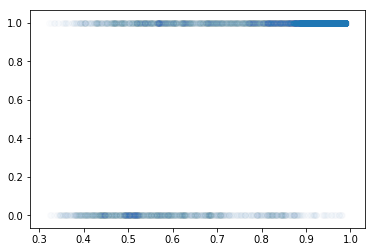

In [29]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [30]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [31]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.9121715231353256

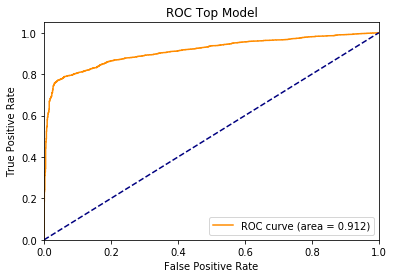

In [32]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

# Controversy Model Baseline

In [35]:
y_test_baseline = controversy_topics_df['controversy_score']
y_pred_baseline = [y_test_baseline.mean()] * len(y_test_baseline)

In [36]:
mean_squared_error(y_test_baseline, y_pred_baseline)

0.01853178758949692

In [37]:
r2_score(y_test_baseline, y_pred_baseline)

0.0

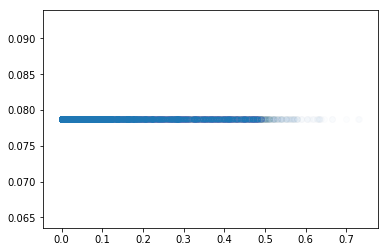

In [38]:
fig, ax = plt.subplots()
ax.scatter(y_test_baseline, y_pred_baseline, alpha=0.01)

# Controversy Top Model

In [92]:
# Make X and y
X = controversy_topics_df.drop(['bill_id', 'controversy_score', 'bill_unique'], 
                             axis=1)
# X = controversy_topics_df[['voter_id', 'voting_agency', 'sponsor_agency', 'party', 'is_minority_party',
#                            'is_secondary_sponsor', 'primary_sponsor_party', 'rep_score', 'bill_length', 
#                            'congress_num', 'num_sponsors', 'years_until_vote', 'bill_num']]

y = controversy_topics_df['controversy_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=709)

In [93]:
# model = RandomForestRegressor(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=500, max_depth=10, random_state=709)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [94]:
mean_squared_error(y_test, y_pred)

0.016022359700102098

In [95]:
r2_score(y_test, y_pred)

0.09924679653293533

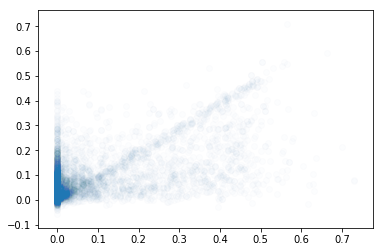

In [84]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.01)

In [44]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [45]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [46]:
features_importances_sorted[0:100]

,0
bill_length,0.138090
bill_num,0.122246
is_secondary_sponsor,0.084709
party,0.077141
is_minority_party,0.071775
rep_score,0.064011
voting_agency,0.053226
congress_num,0.039891
num_sponsors,0.038010
years_until_vote,0.013347


### NLP Playground

In [265]:
# Merge bill_text to X_train and X_test
controversy_billtext_df = controversy_topics_df.merge(bill_text_df_cleaned, how='left', on=['unique_id'])
controversy_billtext_df

,bill_unique,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,...,LITTER,WASHINGTON STATE,CERTIFIED PROFESSIONAL GUARDIANSHIP BOARD,ELECTRICIANS,MUSICIANS,"PUBLIC GUARDIANSHIP, OFFICE",index,htm_url,bill_text,first_date_read
0,1991-92 2E2SSB 5780,275.776119,1.000000,5630.0,1.0,0.514925,0.485075,0.149254,1.0,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,493038,http://app.leg.wa.gov/documents/billdocs/1991-...,to enhancement of employment transition progr...,1991-03-11
1,1991-92 2EHB 2168,246.921569,0.000000,2321.0,0.0,0.450980,0.450980,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,396633,http://app.leg.wa.gov/documents/billdocs/1991-...,to a study of commercial vehicle weight limit...,1991-03-05
2,1991-92 2ESB 5226,281.321918,1.000000,4607.0,1.0,0.506849,0.493151,0.061644,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,466368,http://app.leg.wa.gov/documents/billdocs/1991-...,to terms of office; and amending rcw 43.01.01...,1991-01-24
3,1991-92 2ESB 6004,265.261780,0.471204,5986.0,1.0,0.481675,0.460733,0.000000,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,501556,http://app.leg.wa.gov/documents/billdocs/1991-...,to compacts negotiated under the indian gamin...,1991-06-25
4,1991-92 2ESHB 1025,249.149809,0.041985,53.0,0.0,0.451336,0.449427,0.340649,0.0,0.305556,...,0.0,0.0,0.0,0.0,0.0,0.0,302415,http://app.leg.wa.gov/documents/billdocs/1991-...,"to growth strategies."" i welcome this measur...",NaT
5,1991-92 2ESHB 1037,257.293605,0.139535,90.0,0.0,0.465116,0.465116,0.186047,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,305841,http://app.leg.wa.gov/documents/billdocs/1991-...,to crimes motivated by bigotry or bias; amend...,1991-02-12
6,1991-92 2ESHB 1058,259.265060,0.427711,141.0,0.0,0.472892,0.472892,0.012048,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,307946,http://app.leg.wa.gov/documents/billdocs/1991-...,"to treasurer-managed funds and accounts."" se...",NaT
7,1991-92 2ESHB 1198,250.700508,0.000000,433.0,0.0,0.461929,0.461929,0.086294,0.0,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,319908,http://app.leg.wa.gov/documents/billdocs/1991-...,to the location of electrical facilities; ame...,1991-03-06
8,1991-92 2ESHB 1378,261.875566,0.321267,816.0,0.0,0.470588,0.470588,0.061086,0.0,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,340822,http://app.leg.wa.gov/documents/billdocs/1991-...,to superior court fees; amending rcw 36.18.02...,1991-02-28
9,1991-92 2ESHB 1430,255.395189,0.319588,918.0,0.0,0.481100,0.470790,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,345296,http://app.leg.wa.gov/documents/billdocs/1991-...,to state general obligation and revenue bonds...,1991-04-17


In [424]:
# Make X and y
X = controversy_billtext_df.drop(['bill_unique', 'bill_id', 'controversy_score', 'unique_id', 'first_date_read'], 
                             axis=1)

y = controversy_billtext_df['controversy_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=709)

In [425]:
# Identify bill text
bills_train = X_train['bill_text']
bills_test = X_test['bill_text']
len(bills_train)

8742

In [426]:
controversy_billtext_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13049 entries, 0 to 13048
Columns: 373 entries, bill_unique to first_date_read
dtypes: datetime64[ns](1), float64(366), int64(1), object(5)
memory usage: 37.2+ MB


In [427]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [428]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(2, 4), max_df=0.6, max_features=1000)

In [429]:
fitted = tf.fit(bills_train)

In [430]:
transformed_train = tf.transform(bills_train)

In [431]:
transformed_test = tf.transform(bills_test)

In [432]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [433]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop(['index', 'bill_text', 'htm_url'], axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [434]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop(['index', 'bill_text', 'htm_url'], axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [435]:
X_train = X_train.drop('level_0', axis=1)
X_test = X_test.drop('level_0', axis=1)

In [436]:
X_train.columns[0:20]

Index(['voter_id', 'voting_agency', 'sponsor_agency', 'party',
       'is_minority_party', 'is_secondary_sponsor', 'primary_sponsor_party',
       'rep_score', 'bill_length', 'congress_num', 'num_sponsors',
       'years_until_vote', 'Unnamed: 0', 'bill_num', 'PROPERTY', 'ABORTION',
       'GOVERNMENT OPERATIONS AND POLITICS', 'ACCOUNTANTS AND ACCOUNTING',
       'CIVIL RIGHTS AND LIBERTIES, MINORITY ISSUES', 'NATROPATH'],
      dtype='object')

In [437]:
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=500, max_depth=8, random_state=709)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [438]:
mean_squared_error(y_test, y_pred)

0.014985885553483793

In [439]:
r2_score(y_test, y_pred)

0.15751582964366262

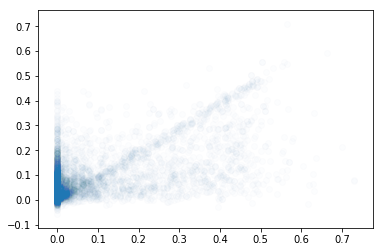

In [85]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.01)

In [421]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [422]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [423]:
features_importances_sorted

,0
bill_length,0.031771
rep_score,0.029018
party,0.028788
bill_num,0.026716
voting_agency,0.025743
is_secondary_sponsor,0.024456
Unnamed: 0,0.023726
voter_id,0.020044
is_minority_party,0.019456
num_sponsors,0.010977
